In [1]:
import kagglehub

path = kagglehub.dataset_download("tpotterer/motley-fool-scraped-earnings-call-transcripts")

print("Path to dataset files:", path)

C:\Users\tnybe\PycharmProjects\stock-screener\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\tnybe\.cache\kagglehub\datasets\tpotterer\motley-fool-scraped-earnings-call-transcripts\versions\1


In [2]:
import os
import pandas as pd

files = os.listdir(path)
print("Files found:", files)

pkl_path = os.path.join(path, "motley-fool-data.pkl")
df = pd.read_pickle(pkl_path)


Files found: ['motley-fool-data.pkl']


In [3]:
print(df.iloc[0])

date                                 Aug 27, 2020, 9:00 p.m. ET
exchange                                           NASDAQ: BILI
q                                                       2020-Q2
ticker                                                     BILI
transcript    Prepared Remarks:\nOperator\nGood day, and wel...
Name: 0, dtype: object


Put date in std format

In [4]:
df['date'] = (df['date']
                    .str.replace(" ET", "", regex=False)
                    .str.replace("p.m.", "PM", regex=False)
                    .str.replace("a.m.", "AM", regex=False))
df['date'] = pd.to_datetime(df['date'])
print(df["date"])

C:\Users\tnybe\AppData\Local\Temp\ipykernel_35200\543151239.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


0       2020-08-27 21:00:00
1       2020-07-30 16:30:00
2       2019-10-23 17:00:00
3       2019-11-06 12:00:00
4       2019-08-07 08:30:00
                ...        
18750   2021-11-09 13:00:00
18751   2021-11-18 12:00:00
18752   2022-02-08 11:00:00
18753   2022-02-28 16:30:00
18754   2021-08-12 09:00:00
Name: date, Length: 18755, dtype: datetime64[ns]


In [5]:
import spacy

spacy.require_gpu()

print("Loading Transformer model...")
nlp = spacy.load("en_core_web_trf")

def apply_mask(doc):
    text = doc.text
    replacements = []

    for ent in doc.ents:
        if ent.label_ in ["ORG", "PERSON"]:
            replacements.append((ent.start_char, ent.end_char, f"<{ent.label_}>"))

    replacements.sort(key=lambda x: x[0], reverse=True)

    new_text = text
    for start, end, tag in replacements:
        new_text = new_text[:start] + tag + new_text[end:]

    return new_text

Loading Transformer model...


In [6]:
from tqdm import tqdm

print("Processing on GPU...")
texts = df['transcript'].fillna("").astype(str).tolist()

doc_generator = nlp.pipe(texts, batch_size=1, disable=["lemmatizer"])

masked_transcripts = []
for doc in tqdm(doc_generator, total=len(texts), desc="Masking Transcripts"):
    masked_transcripts.append(apply_mask(doc))

df['transcript_masked'] = masked_transcripts
print("Done!")

Processing on GPU...


Masking Transcripts:   0%|          | 0/18755 [00:00<?, ?it/s]C:\Users\tnybe\PycharmProjects\stock-screener\.venv\Lib\site-packages\thinc\util.py:395: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  dlpack_tensor = xp_tensor.toDlpack()  # type: ignore
Masking Transcripts: 100%|██████████| 18755/18755 [15:41:46<00:00,  3.01s/it]   


Done!


In [15]:

print(df.iloc[5]["transcript"])


Prepared Remarks:
Operator
Good afternoon, and welcome to the Green Dot Third Quarter 2020 Earnings Conference Call. [Operator Instructions] I would now like to turn the conference over to Allison Lubert, Vice President of Communications. Please go ahead.
Alison Cahill Lubert -- Vice President Corporate Communications
Thank you, and good afternoon, everyone. Today, we are discussing Green Dot's third quarter 2020 financial and operating results. Following remarks, we'll open the call for questions. Our most recent earnings release that accompanies this call and webcast can be found at ir.greendot.com. As a reminder, our comments may include forward-looking statements and expectations regarding future results and performance. Please refer to the cautionary language in the earnings release and in Green Dot's filings with the Securities and Exchange Commission, including our most recent Form 10-K and 10-Q for additional information concerning factors that could cause actual results to dif

In [16]:
print(df.iloc[5]["transcript_masked"])

Prepared Remarks:
Operator
Good afternoon, and welcome to the <ORG> Third Quarter 2020 Earnings Conference Call. [Operator Instructions] I would now like to turn the conference over to <PERSON>, Vice President of <ORG>. Please go ahead.
<PERSON> -- Vice President Corporate Communications
Thank you, and good afternoon, everyone. Today, we are discussing <ORG> third quarter 2020 financial and operating results. Following remarks, we'll open the call for questions. Our most recent earnings release that accompanies this call and webcast can be found at ir.greendot.com. As a reminder, our comments may include forward-looking statements and expectations regarding future results and performance. Please refer to the cautionary language in the earnings release and in <ORG> filings with <ORG>, including our most recent Form 10-K and <ORG> for additional information concerning factors that could cause actual results to differ materially from the forward-looking statements.
During the call, we'll 

In [9]:
output_path = "motley_fool_masked.pkl"
df.to_pickle(output_path)
print(f"Saved masked dataframe to {output_path}")

Saved masked dataframe to motley_fool_masked.pkl


In [17]:
print(df.iloc[1]["transcript_masked"])

Prepared Remarks:
Operator
Thank you for standing by. This is the conference operator. Welcome to <ORG> Third Quarter 2020 Earnings Conference Call. [Operator Instructions] I would now like to turn the conference over to <PERSON>, Chief Financial Officer. Please go ahead.
<PERSON> -- Senior Vice President and Chief Financial Officer
Thank you. Good afternoon everyone. With me on the call is <PERSON>, our Chairman and Chief Executive Officer. Our call is being recorded and will be available for playback, the details of which are in our press release issued earlier today.
As in the past, our comments will include forward-looking statements about the company's performance based on our views of <ORG>'s businesses and the environments in which they operate. Such statements are subject to inherent risks and uncertainties that can change as the world changes. Please see the cautionary statements in today's press release and in our various <ORG> filings.
Finally, some of today's remarks will a

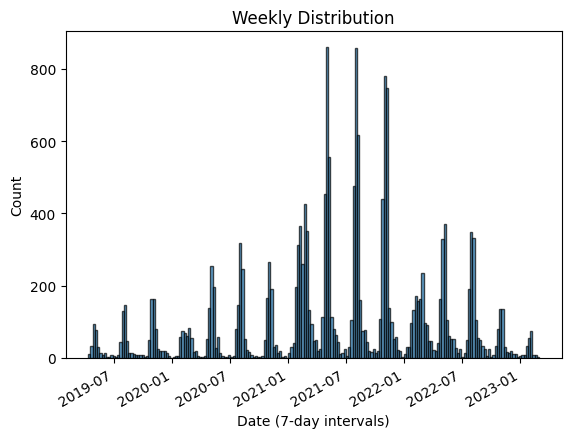

In [19]:
import matplotlib.pyplot as plt
bins = pd.date_range(start=df['date'].min(),
                     end=df['date'].max() + pd.Timedelta(days=7),
                     freq='7D')

plt.hist(df['date'], bins=bins, edgecolor='black', alpha=0.7)

plt.title('Weekly Distribution')
plt.xlabel('Date (7-day intervals)')
plt.ylabel('Count')

plt.gcf().autofmt_xdate()

plt.show()

